# VQ-VAE on CIFAR10

This notebook implements to model described in the article [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937.pdf). The main motivation of the article is to find a way to avoid the "posterior collapse" issue encountered when coupling VAE with autoregressive models such as [PixelCNN](https://arxiv.org/abs/1606.05328) to generate images. The solution proposed consists in creating a discrete latent space, over which a posterior is learned (training in two stages). <br>
In this notebook, I only implemented the parts related the learning of the discrete latent space, referred as codebook, in two different ways.

## I. Data preparation

In [1]:
import jax
from jax import lax, random, numpy as jnp
import numpy as np
from flax import linen as nn
from flax.training import train_state, orbax_utils
import optax
import orbax.checkpoint as ocp
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Any
from jax.typing import ArrayLike

import logging

In [2]:
# Globales
batch_size = 256
workers = 8
learning_rate = 0.001
epochs = 100
seed = 654321
# Commitment cost
beta = 0.25
# 1 - smoothing factor for EMA
gamma = 0.99
num_embeddings = 512
latent_dim = 64

In [3]:
def calc_mean_std(dataset):
    """ Computes mean and std of the dataset in order to normalize the images """
    img = torch.stack([data[0] for data in dataset]).cuda()
    return img.mean(axis=(0, 2, 3)).cpu().numpy(), img.std(axis=(0, 2, 3)).cpu().numpy()

In [4]:
cifar10 = CIFAR10(root="./data", train=True, download=True, transform=T.ToTensor())
cifar10_mean, cifar10_std = calc_mean_std(cifar10)
cifar10_mean, cifar10_std

Files already downloaded and verified


(array([0.49139968, 0.48215842, 0.44653094], dtype=float32),
 array([0.24703224, 0.24348514, 0.26158783], dtype=float32))

In [3]:
def numpy_normalize(x, mean, std):
    """ Scales values from [0, 255] to [0, 1] and normalizes images with dataset moments """
    x = np.array(x, dtype=jnp.float32) / 255.
    return (x - mean) / std


def numpy_collate(batch):
    """ Stack elements in batches of numpy arrays instead of Torch tensors """
    transposed_data = list(zip(*batch))
    imgs = np.stack(transposed_data[0])
    labels = np.array(transposed_data[1])

    return imgs, labels

In [4]:
cifar10_mean = (0.49139968, 0.48215842, 0.44653094)
cifar10_std = (0.24703224, 0.24348514, 0.26158783)

In [5]:
trainset = CIFAR10(root="./data", train=True, download=True,
                   transform=lambda x: numpy_normalize(x, cifar10_mean, cifar10_std))
testset = CIFAR10(root="./data", train=False, download=True,
                  transform=lambda x: numpy_normalize(x, cifar10_mean, cifar10_std))
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=workers, collate_fn=numpy_collate, drop_last=True)
testloader = DataLoader(testset, batch_size, shuffle=False, num_workers=workers, collate_fn=numpy_collate, drop_last=True)
len(trainset), len(testset), len(trainloader), len(testloader)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000, 195, 39)

In [6]:
trainset[0][0].shape

(32, 32, 3)

## II. Training the codebook with Gradient Descent (codebook loss)

The first method proposed to learn the codebook is through Gradient Descent with the following loss :
$$L = \underbrace{\log(p(x|z_q(x)))}_{\text{reconstruction loss}} +  \underbrace{\lVert\textbf{sg}[z_e(x)] - e \rVert_2^2}_{\text{codebook loss}} + \underbrace{\beta \lVert z_e(x)- \textbf{sg}[e]\rVert_2^2}_{\text{commitment loss}} $$
where
> $z_q$ is the embedding of the data generated from the codebook <br>
> $z_e$ is the output of the encoder <br>
> $sg$ is the stop gradient operator. It is used to pass the gradient from the decoder to the encoder through the non-differentiable argmin function (is $z_q$ and $z_e$ are close enough, the approximation makes sense) <br>
> $\beta$ is the commitment cost, used to bound the value taken by the output of the encoder

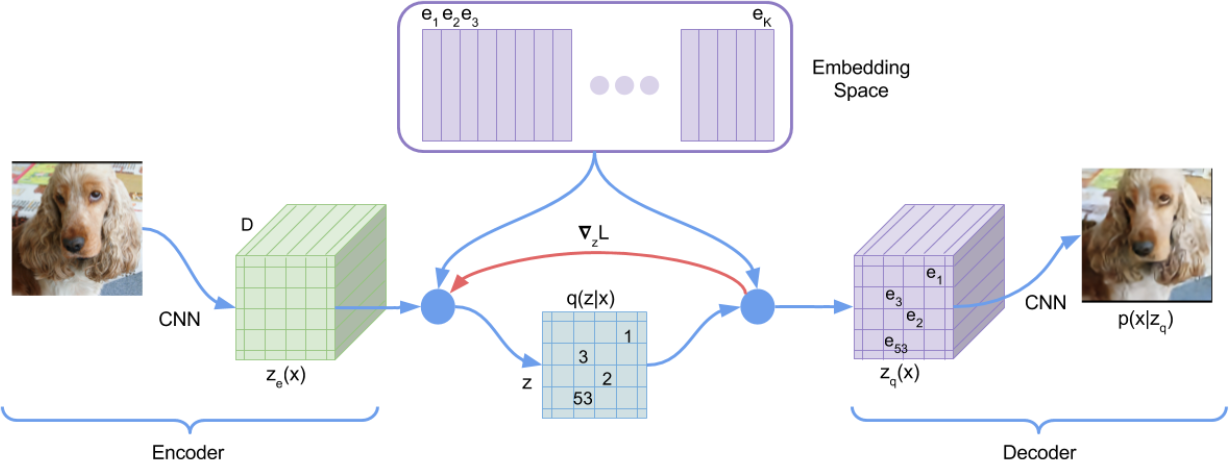

### 2.1. Model

In [7]:
class ResnetBlock(nn.Module):
    # Use of GroupNorm and swish activation function, as in Stable Diffusion without time embedding (more recent than VQVAE)
    # inspiration from https://github.com/huggingface/diffusers/blob/v0.21.0/src/diffusers/models/resnet_flax.py
    out_channels: int

    def setup(self):
        self.norm1 = nn.GroupNorm()
        self.conv1 = nn.Conv(self.out_channels, kernel_size=(3, 3), strides=(1, 1), padding=1)
        self.norm2 = nn.GroupNorm()
        self.conv2 = nn.Conv(self.out_channels, kernel_size=(3, 3), strides=(1, 1), padding=1)

    def __call__(self, x):
        h = nn.swish(self.norm1(x))
        h = self.conv1(h)
        h = nn.swish(self.norm2(h))
        h = self.conv2(h)
        return x + h


class Encoder(nn.Module):
    latent_dim: int
    num_embeddings: int

    def setup(self):
        # H_out = H_in / 2
        self.conv1 = nn.Conv(self.latent_dim // 2, kernel_size=(4, 4), strides=(2, 2), padding=1)
        # H_out = H_in / 2
        self.conv2 = nn.Conv(self.latent_dim, kernel_size=(4, 4), strides=(2, 2), padding=1)
        # H_out = H_in
        self.conv3 = nn.Conv(self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1)
        self.res_block1 = ResnetBlock(self.latent_dim)
        self.res_block2 = ResnetBlock(self.latent_dim)

    def __call__(self, x):
        x = nn.relu(self.conv1(x))
        x = nn.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        return x

In [8]:
class VectorQuantizer(nn.Module):
    # inspired from https://github.com/google-deepmind/dm-haiku/blob/main/haiku/_src/nets/vqvae.py
    num_embeddings: int
    embedding_dim: int
    beta: float

    def setup(self):
        # Embedding_dim as first axis to avoid transpose in distance computation
        # but requires transposing when creating the quantized version in return
        self.codebook = self.param('codebook', nn.initializers.lecun_uniform(),
                                   (self.embedding_dim, self.num_embeddings))

    def __call__(self, inputs):
        flat_inputs = jnp.reshape(inputs, (-1, self.embedding_dim))
        distances = (jnp.sum(jnp.square(flat_inputs), 1, keepdims=True) -
                     2 * jnp.matmul(flat_inputs, self.codebook) +
                     jnp.sum(jnp.square(self.codebook), 0, keepdims=True))
        encoding_indices = jnp.argmin(distances, 1)
        flat_quantized = jnp.take(self.codebook, encoding_indices, axis=1).swapaxes(1, 0)
        quantized = jnp.reshape(flat_quantized, inputs.shape)

        # Losses computation
        codebook_loss = jnp.mean(jnp.square(quantized - lax.stop_gradient(inputs)))
        commitment_loss = self.beta * jnp.mean(jnp.square(lax.stop_gradient(quantized) - inputs))

        # Straight Through Estimator : returns the value of the quantized latent space
        # and multiplies gradient by 1 in chain rule, as input = output
        # - i.e. gradient from the decoder passed directly to the encoder in backprop phase
        ste = inputs + lax.stop_gradient(quantized - inputs)

        # Perplexity computation
        encodings = jax.nn.one_hot(encoding_indices, self.num_embeddings, dtype=distances.dtype)
        avg_probs = jnp.mean(encodings, 0)
        perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))

        return ste, perplexity, codebook_loss, commitment_loss

In [9]:
class Upsample(nn.Module):
    # Replace TransposeConv2d by Upsample block to avoid checkerboard artifacts
    # Upsample by factor upfactor, followed by convolution so that the model can learn parameters
    # cf. https://distill.pub/2016/deconv-checkerboard/
    out_channels: int
    upfactor: int

    def setup(self):
        # H_out = H_in
        self.conv = nn.Conv(self.out_channels, kernel_size=(3, 3), strides=(1, 1), padding=1)

    def __call__(self, inputs):
        batch, height, width, channels = inputs.shape
        hidden_states = jax.image.resize(inputs,
                                         shape=(batch, height * self.upfactor, width * self.upfactor, channels),
                                         method="bilinear")
        return self.conv(hidden_states)


class Decoder(nn.Module):
    latent_dim: int

    def setup(self):
        self.res_block1 = ResnetBlock(self.latent_dim)
        self.res_block2 = ResnetBlock(self.latent_dim)
        self.upsample1 = Upsample(out_channels=self.latent_dim // 2, upfactor=2)
        self.upsample2 = Upsample(out_channels=3, upfactor=2)

    def __call__(self, x):
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = nn.relu(self.upsample1(x))
        return self.upsample2(x)

In [10]:
class VQVAE(nn.Module):
    latent_dim: int
    num_embeddings: int
    beta: float

    def setup(self):
        self.encoder = Encoder(latent_dim=self.latent_dim, num_embeddings=self.num_embeddings)
        self.vector_quantizer = VectorQuantizer(num_embeddings=self.num_embeddings,
                                                embedding_dim=self.latent_dim, beta=self.beta)
        self.decoder = Decoder(latent_dim=self.latent_dim)

    def __call__(self, x):
        ze = self.encoder(x)
        zq, perplexity, codebook_loss, commitment_loss = self.vector_quantizer(ze)
        return self.decoder(zq), perplexity, codebook_loss, commitment_loss

### 2.2. Training

In [18]:
def create_train_state(model, rng, learning_rate):
    """ Instanciate the state outside of the training loop """
    params = model.init(rng, jnp.ones([1, 32, 32, 3]))['params']
    opti = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply,
                                         params=params, tx=opti)


@jax.jit
def train_step(state, batch):
    """ Train for a single step """
    def loss_fn(params):
        x_recon, perplexity, codebook_loss, commitment_loss = state.apply_fn({'params': params}, batch[0])
        recon_loss = optax.squared_error(predictions=x_recon, targets=batch[0]).mean()
        metrics = {"perplexity": perplexity, "recon_loss": recon_loss,
                   "codebook_loss": codebook_loss, "commitment_loss": commitment_loss}
        return recon_loss + codebook_loss + commitment_loss, metrics

    # Update parameters with gradient descent
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, metrics), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, metrics


@jax.jit
def eval_step(state, batch):
    """ Computes the metric on the test batch (code already included in train_step for train batch) """
    x_recon, perplexity, codebook_loss, commitment_loss = state.apply_fn({'params': state.params}, batch[0])
    recon_loss = optax.l2_loss(predictions=x_recon, targets=batch[0]).mean()
    metrics = {"perplexity": perplexity, "recon_loss": recon_loss,
               "codebook_loss": codebook_loss, "commitment_loss": commitment_loss}
    return state, recon_loss + codebook_loss + commitment_loss, metrics

In [12]:
# Initialization
model = VQVAE(num_embeddings=num_embeddings, latent_dim=latent_dim, beta=beta)
init_rng = random.PRNGKey(seed)
state = create_train_state(model, init_rng, learning_rate)
del init_rng

In [13]:
%%time
# Training loop
epoch = tqdm(range(epochs))
loss_train_tot, loss_test_tot, perplexity_train_tot, perplexity_test_tot = [], [], [], []
recon_loss_tot, codebook_loss_tot, commitment_loss_tot = [], [], []
for e in epoch:
    loss_train, loss_test, perplexity_train, perplexity_test = [], [], [], []
    recon_loss, codebook_loss, commitment_loss = [], [], []
    torch.manual_seed(seed)
    for batch in trainloader:
        state, loss, metrics = train_step(state, batch)
        loss_train.append(loss)
        perplexity_train.append(metrics["perplexity"].item())
        recon_loss.append(metrics["recon_loss"].item())
        codebook_loss.append(metrics["codebook_loss"].item())
        commitment_loss.append(metrics["commitment_loss"].item())
    recon_loss_tot.append(np.mean(recon_loss))
    codebook_loss_tot.append(np.mean(codebook_loss))
    commitment_loss_tot.append(np.mean(commitment_loss))

    # Compute metrics on the test set after each training epoch
    test_state = state
    for batch in testloader:
        test_state, loss, metrics = eval_step(test_state, batch)
        loss_test.append(loss)
        perplexity_test.append(metrics["perplexity"].item())
    loss_train_tot.append(np.mean(loss_train))
    loss_test_tot.append(np.mean(loss_test))
    perplexity_train_tot.append(np.mean(perplexity_train))
    perplexity_test_tot.append(np.mean(perplexity_test))
    epoch.set_description(f"Epoch: {e+1}/{epochs} - Train Loss: {np.mean(loss_train):.4f} - Test loss: {np.mean(loss_test):.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 7min 36s, sys: 1min 36s, total: 9min 12s
Wall time: 9min 9s


In [14]:
ckpt = {'model': state, 'loss_train': loss_train_tot, 'loss_test': loss_test_tot,
        'perplexity_train': perplexity_train_tot, 'perplexity_test': perplexity_test_tot,
        'recon_loss': recon_loss_tot, 'codebook_loss': codebook_loss_tot,
        'commitment_loss': commitment_loss_tot}
orbax_checkpointer = ocp.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save(f"./vqvae_std_lr{learning_rate}_e{epochs}", ckpt, save_args=save_args)

### 2.3. Results

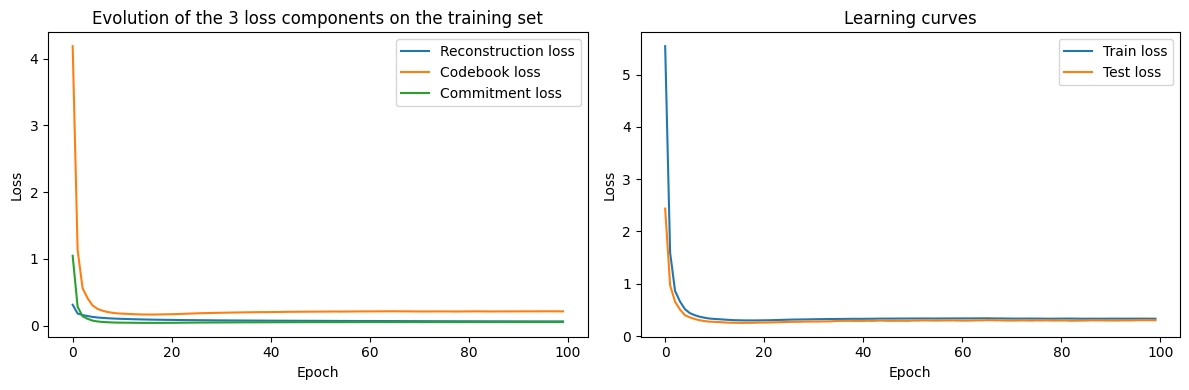

In [15]:
plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(epochs), recon_loss_tot, label="Reconstruction loss")
ax.plot(np.arange(epochs), codebook_loss_tot, label="Codebook loss")
ax.plot(np.arange(epochs), commitment_loss_tot, label="Commitment loss")
ax.set_title("Evolution of the 3 loss components on the training set")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(np.arange(epochs), loss_train_tot, label="Train loss")
ax.plot(np.arange(epochs), loss_test_tot, label="Test loss")
ax.set_title("Learning curves")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.tight_layout()

We can notice that the losses decrease fairly rapidly and remain low, which suggests the model is learning well without overfitting. The codebook loss increases slightly after around 20 epochs, but stabilises relatively quickly. <br>
The losses are useful for analysing the learning behaviour but are a poor metric to gauge the quality of the codebook learned. The metric used by DeepMind to this end is the **perplexity** (computed as $e^\textit{entropy}$), frequently encountered in the context of NLP to measure how well a language model can predict a sequence of words. In NLP, lower perplexity scores are preferred, as they indicate that the model can predict the next words more accurately. In the context of VQ VAE, **higher** perplexity values are preferred as they reveal that the model can potentially use a high number of embeddings from the codebook to generate an image, i.e. that it is effectively utilizing the entire codebook, which can lead to better data representation and reconstruction (more expressive latent space). On the contrary, a low perplexity score would suggest overfitting, i.e. the model memorizing a few data points instead of learning a useful latent representation. <br>
The curves below the codebook learned is expressive. Unlike the losses curves, these ones do not seem to plateau.

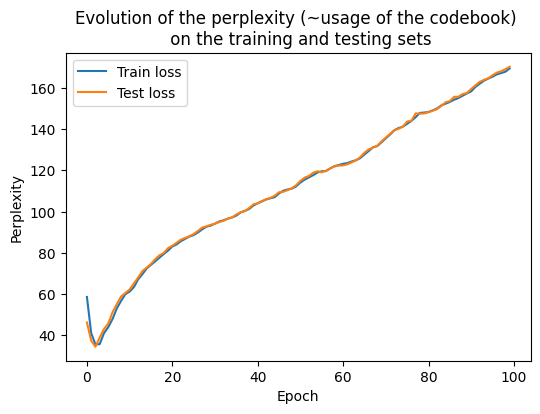

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(epochs), perplexity_train_tot, label="Train loss")
plt.plot(np.arange(epochs), perplexity_test_tot, label="Test loss")
plt.title("Evolution of the perplexity (~usage of the codebook) \n on the training and testing sets")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

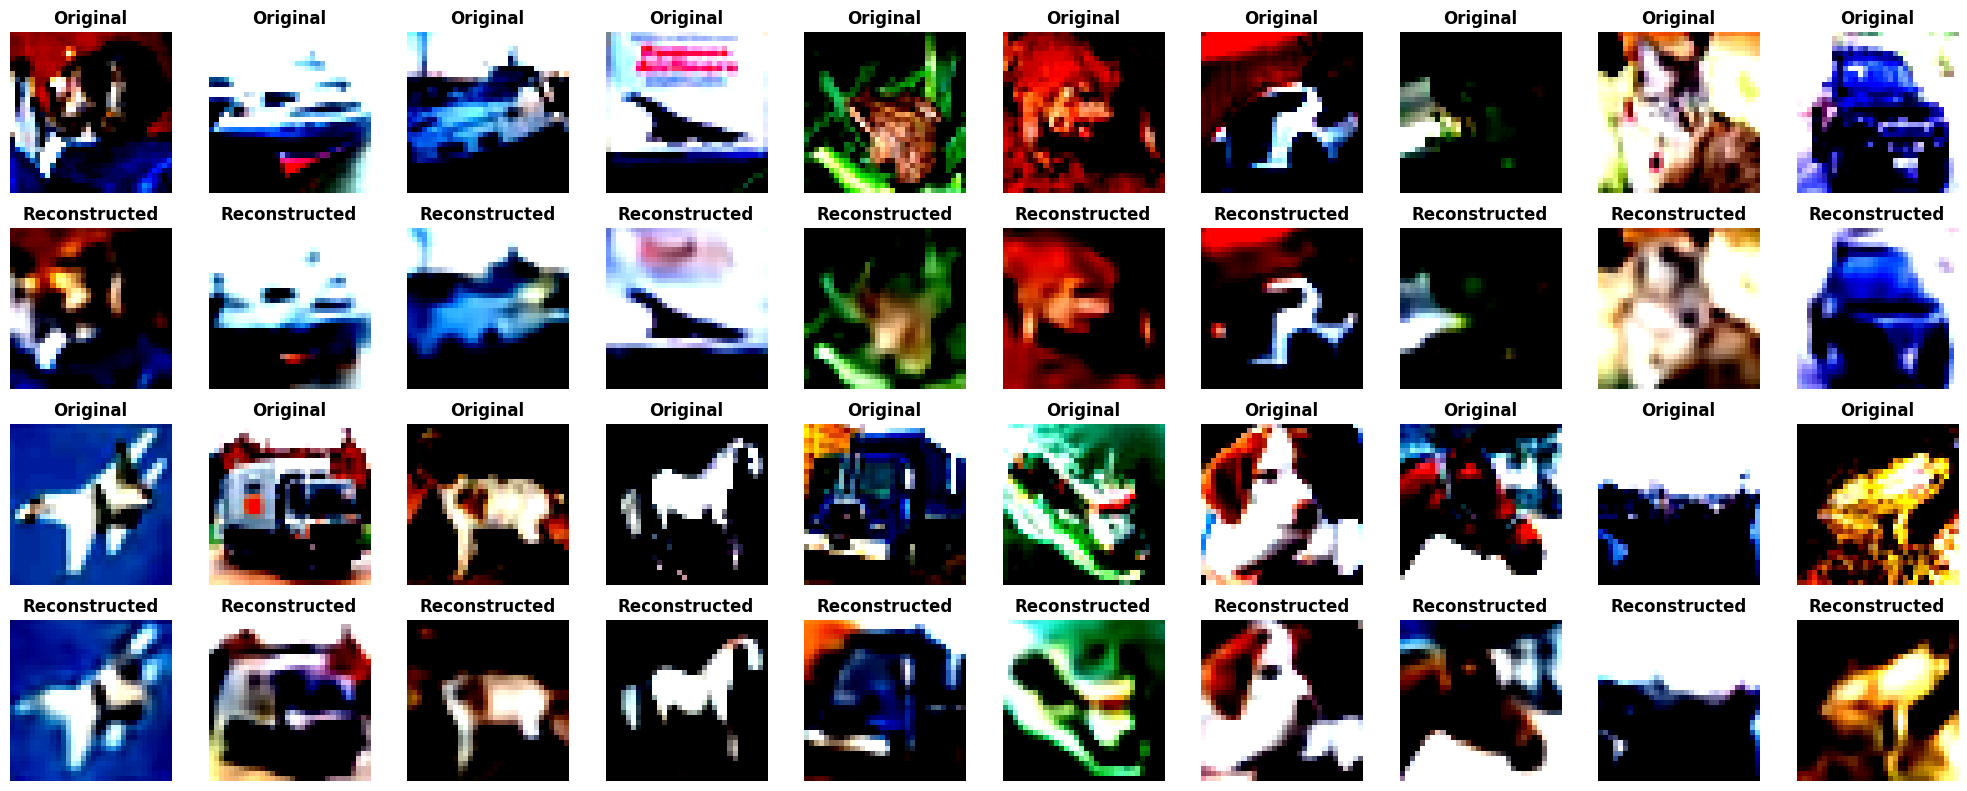

In [17]:
# Disable annoying warning about clipping image values
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

imgs, _ = next(iter(testloader))
rec, _, _, _ = state.apply_fn({'params': state.params}, imgs)
plt.figure(figsize=(20, 8))
for i in range(10):
    ax = plt.subplot(4, 10, i + 1)
    img = imgs[i].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(4, 10, i + 11)
    img = rec[i].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Reconstructed", fontweight="bold")
    ax = plt.subplot(4, 10, i + 21)
    img = imgs[i+10].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(4, 10, i + 31)
    img = rec[i+10].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Reconstructed", fontweight="bold")
plt.tight_layout()

# Set warning level back
logger.setLevel(old_level)

The reconstructed images are quite blurry, but this is expected given the diversity and low resoltion of the original images of the dataset.

## III. Training the codebook with EMA

Another method of training is described in the appendix of the article, using Exponential Moving Averages (EMA). The `codebook loss` term is removed from the loss equation. Instead, exponential moving averages are used as an online version of K-means to update the codebook. <br>
This method is supposed to converge faster, as there is no trick / approximation to train the codebook. Besides, the use of EMA is meant to make the training of the codebook less dependant on the choice of the optimizer and its hyperparameters.

### 3.1. Model

In [11]:
class EMA(nn.Module):
    # inspired from https://github.com/deepmind/dm-haiku/blob/master/haiku/_src/moving_averages.py
    decay: float
    shape: list
    dtype: Any = jnp.float32

    def setup(self):
        self.hidden = self.variable('batch_stats', 'hidden',
                                    lambda shape: jnp.zeros(shape, dtype=self.dtype),
                                    self.shape)
        self.average = self.variable('batch_stats', 'average',
                                     lambda shape: jnp.zeros(shape, dtype=self.dtype),
                                     self.shape)
        self.counter = self.variable('batch_stats', 'counter',
                                     lambda shape: jnp.zeros(shape, dtype=jnp.int32),
                                     ())

    def __call__(self, value, update_stats):
        counter = self.counter.value + 1
        decay = jax.lax.convert_element_type(self.decay, value.dtype)
        one = jnp.ones([], value.dtype)
        hidden = self.hidden.value * decay + value * (one - decay)
        average = hidden
        # Apply zero-debiasing
        average /= (one - jnp.power(decay, counter))
        if update_stats:
            self.counter.value = counter
            self.hidden.value = hidden
            self.average.value = average
        return average


class VectorQuantizerEMA(nn.Module):
    # Method described in the appendix of the original article https://arxiv.org/pdf/1711.00937.pdf
    # Codebook loss replaced by EMA update of the codebook
    num_embeddings: int
    embedding_dim: int
    rng: ArrayLike
    beta: float
    gamma: float
    epsilon: float = 1e-5

    def setup(self):
        # This time the codebook is non-trainable, only updated with EMA
        self.codebook = self.variable('batch_stats', 'codebook',
                                      nn.initializers.lecun_uniform(), self.rng,
                                      (self.embedding_dim, self.num_embeddings))
        # Non-trainable parameter to store the number of elements in each cluster (around each embedding)
        self.ema_cluster_size = EMA(self.gamma, (self.num_embeddings))
        # Non-trainable parameter to store the sum of elements in each cluster
        # (cf. (7) in the annex of the article)
        self.ema_dw = EMA(self.gamma, (self.embedding_dim, self.num_embeddings))

    def __call__(self, inputs, training: bool):
        flat_inputs = jnp.reshape(inputs, (-1, self.embedding_dim))
        distances = (jnp.sum(jnp.square(flat_inputs), 1, keepdims=True) -
                     2 * jnp.matmul(flat_inputs, self.codebook.value) +
                     jnp.sum(jnp.square(self.codebook.value), 0, keepdims=True))
        encoding_indices = jnp.argmin(distances, 1)
        encodings = jax.nn.one_hot(encoding_indices, self.num_embeddings, dtype=distances.dtype)
        flat_quantized = jnp.take(self.codebook.value, encoding_indices, axis=1).swapaxes(1, 0)
        quantized = jnp.reshape(flat_quantized, inputs.shape)
        loss = self.beta * jnp.mean(jnp.square(jax.lax.stop_gradient(quantized) - inputs))

        # Update the codebook with EMA only if the model is in training mode
        if training:
            # Number of closest inputs for each embedding in the codebook (size: num_embeddings)
            cluster_size = jnp.sum(encodings, axis=0)
            updated_ema_cluster_size = self.ema_cluster_size(cluster_size, update_stats=True)
            # Sum of inputs within clusters (equation (7))
            dw = jnp.matmul(flat_inputs.T, encodings)
            updated_ema_dw = self.ema_dw(dw, update_stats=True)
            # Laplace smoothing of cluster size / nb of elements
            n = jnp.sum(updated_ema_cluster_size)
            updated_ema_cluster_size = ((updated_ema_cluster_size + self.epsilon) /
                                        (n + self.num_embeddings * self.epsilon) * n)
            normalised_updated_ema_w = (updated_ema_dw / jnp.reshape(updated_ema_cluster_size, [1, -1]))

            self.codebook.value = normalised_updated_ema_w

        # Straight Through Estimator : returns the value of the quantized latent space
        # and multiplies gradient by 1 in chain rule, as input = output
        # - i.e. gradient from the decoder passed directly to the encoder in backprop phase
        ste = inputs + lax.stop_gradient(quantized - inputs)

        # Perplexity computation
        avg_probs = jnp.mean(encodings, 0)
        perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))

        return ste, perplexity, loss

In [12]:
class VQVAE_EMA(nn.Module):
    latent_dim: int
    num_embeddings: int
    rng: ArrayLike
    beta: float
    gamma: float
    epsilon: float = 1e-5

    def setup(self):
        self.encoder = Encoder(latent_dim=self.latent_dim, num_embeddings=self.num_embeddings)
        self.vector_quantizer = VectorQuantizerEMA(num_embeddings=self.num_embeddings,
                                                   embedding_dim=self.latent_dim, rng=self.rng,
                                                   beta=self.beta, gamma=self.gamma, epsilon=self.epsilon)
        self.decoder = Decoder(latent_dim=self.latent_dim)

    def __call__(self, x, training):
        ze = self.encoder(x)
        zq, perplexity, loss = self.vector_quantizer(ze, training)
        return self.decoder(zq), perplexity, loss

### 3.2. Training

In [13]:
class TrainStateEMA(train_state.TrainState):
    batch_stats: Any


def create_train_state_EMA(model, rng, learning_rate):
    """ Instanciate the state outside of the training loop """
    variables = model.init(rng, jnp.ones([1, 32, 32, 3]), training=True, mutable=True)
    opti = optax.adam(learning_rate)
    return TrainStateEMA.create(apply_fn=model.apply, params=variables['params'],
                                batch_stats=variables['batch_stats'], tx=opti)


@jax.jit
def train_step_EMA(state, batch):
    """ Train for a single step """
    def loss_fn(params, batch_stats):
        (x_recon, perplexity, commitment_loss), _ = state.apply_fn({'params': params,
                                                                          'batch_stats': batch_stats},
                                                                         batch[0], training=True,
                                                                         mutable=True)
        recon_loss = optax.squared_error(predictions=x_recon, targets=batch[0]).mean()
        metrics = {"perplexity": perplexity, "recon_loss": recon_loss,
                   "commitment_loss": commitment_loss}
        return recon_loss + commitment_loss, metrics

    # Update parameters with gradient descent
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, metrics), grads = grad_fn(state.params, state.batch_stats)
    state = state.apply_gradients(grads=grads)
    return state, loss, metrics


@jax.jit
def eval_step_EMA(state, batch):
    """ Computes the metric on the test batch (code already included in train_step for train batch) """
    x_recon, perplexity, commitment_loss = state.apply_fn({'params': state.params,
                                                           'batch_stats': state.batch_stats},
                                                          batch[0], training=False)
    recon_loss = optax.l2_loss(predictions=x_recon, targets=batch[0]).mean()
    metrics = {"perplexity": perplexity, "recon_loss": recon_loss,
               "commitment_loss": commitment_loss}
    return state, recon_loss + commitment_loss, metrics

In [21]:
# Initialization
init_rng = random.PRNGKey(seed)
init_rng, codebook_rng = random.split(init_rng)
model = VQVAE_EMA(num_embeddings=num_embeddings, latent_dim=latent_dim, rng=codebook_rng,
                  beta=beta, gamma=gamma)
state = create_train_state_EMA(model, init_rng, learning_rate)
del init_rng

In [22]:
%%time
# Training loop
epoch = tqdm(range(epochs))
loss_train_tot, loss_test_tot, perplexity_train_tot, perplexity_test_tot = [], [], [], []
recon_loss_tot, commitment_loss_tot = [], []
for e in epoch:
    loss_train, loss_test, perplexity_train, perplexity_test = [], [], [], []
    recon_loss, commitment_loss = [], []
    torch.manual_seed(seed)
    for batch in trainloader:
        state, loss, metrics = train_step_EMA(state, batch)
        loss_train.append(loss)
        perplexity_train.append(metrics["perplexity"].item())
        recon_loss.append(metrics["recon_loss"].item())
        commitment_loss.append(metrics["commitment_loss"].item())
    recon_loss_tot.append(np.mean(recon_loss))
    commitment_loss_tot.append(np.mean(commitment_loss))

    # Compute metrics on the test set after each training epoch
    test_state = state
    for batch in testloader:
        test_state, loss, metrics = eval_step_EMA(test_state, batch)
        loss_test.append(loss)
        perplexity_test.append(metrics["perplexity"].item())
    loss_train_tot.append(np.mean(loss_train))
    loss_test_tot.append(np.mean(loss_test))
    perplexity_train_tot.append(np.mean(perplexity_train))
    perplexity_test_tot.append(np.mean(perplexity_test))
    epoch.set_description(f"Epoch: {e+1}/{epochs} - Train Loss: {np.mean(loss_train):.4f} - Test loss: {np.mean(loss_test):.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 7min 19s, sys: 1min 41s, total: 9min 1s
Wall time: 8min 57s


In [23]:
ckpt = {'model': state, 'loss_train': loss_train_tot, 'loss_test': loss_test_tot,
       'perplexity_train': perplexity_train_tot, 'perplexity_test': perplexity_test_tot,
       'recon_loss': recon_loss_tot, 'commitment_loss': commitment_loss_tot}
orbax_checkpointer = ocp.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save(f"./vqvae_ema_lr{learning_rate}_e{epochs}", ckpt, save_args=save_args)

### 3.3. Results

In [20]:
orbax_checkpointer = ocp.PyTreeCheckpointer()
std_model = VQVAE(num_embeddings=num_embeddings, latent_dim=latent_dim, beta=beta)
init_rng = random.PRNGKey(seed)
empty_state = create_train_state(std_model, init_rng, learning_rate)
del init_rng
target = {'model': empty_state, 'loss_train': [], 'loss_test': [],
        'perplexity_train': [], 'perplexity_test': [], 'recon_loss': [],
          'codebook_loss': [], 'commitment_loss': []}
std_results = orbax_checkpointer.restore(f"./vqvae_std_lr{learning_rate}_e{epochs}", item=target)
std_rec_loss = std_results['recon_loss']
std_com_loss = std_results['commitment_loss']
std_train_loss = std_results['loss_train']
std_train_perp = std_results['perplexity_train']
std_state = std_results['model']

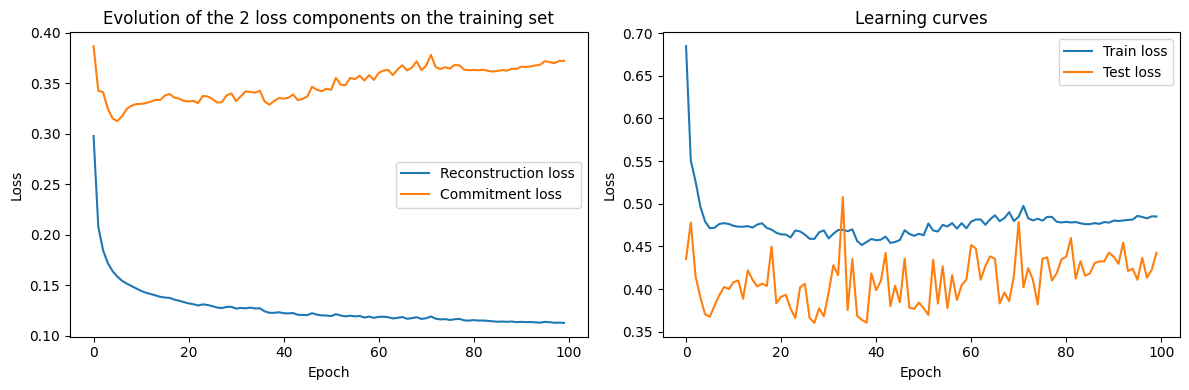

In [25]:
plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(epochs), recon_loss_tot, label="Reconstruction loss")
ax.plot(np.arange(epochs), commitment_loss_tot, label="Commitment loss")
ax.set_title("Evolution of the 2 loss components on the training set")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(np.arange(epochs), loss_train_tot, label="Train loss")
ax.plot(np.arange(epochs), loss_test_tot, label="Test loss")
ax.set_title("Learning curves")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.tight_layout()

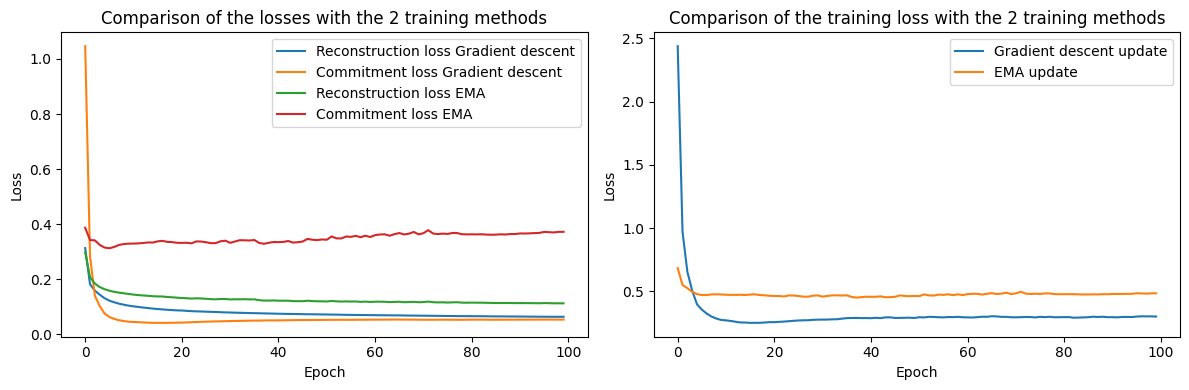

In [27]:
plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(epochs), std_rec_loss, label="Reconstruction loss Gradient descent")
ax.plot(np.arange(epochs), std_com_loss, label="Commitment loss Gradient descent")
ax.plot(np.arange(epochs), recon_loss_tot, label="Reconstruction loss EMA")
ax.plot(np.arange(epochs), commitment_loss_tot, label="Commitment loss EMA")
ax.set_title("Comparison of the losses with the 2 training methods")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(np.arange(epochs), std_train_loss, label="Gradient descent update")
ax.plot(np.arange(epochs), loss_train_tot, label="EMA update")
ax.set_title("Comparison of the training loss with the 2 training methods")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.tight_layout()

This time, the commitment loss does not seem to stabilize as well as with the Gradient Descent method. Its influence is quite visible on the learning curves (as the reconstruction loss is once again really low). <br>
Looking at the perplexity, it seems that the training is indeed faster as a plateau is reached quite fast. However, the perplexity values with EMA are quite lower than the ones obtained with Gradient Descent.

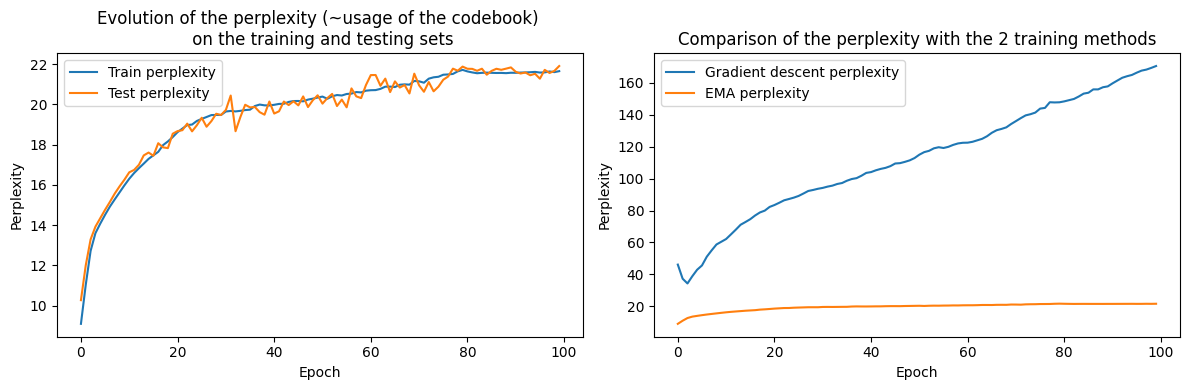

In [30]:
plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(epochs), perplexity_train_tot, label="Train perplexity")
ax.plot(np.arange(epochs), perplexity_test_tot, label="Test perplexity")
ax.set_title("Evolution of the perplexity (~usage of the codebook) \n on the training and testing sets")
ax.set_xlabel("Epoch")
ax.set_ylabel("Perplexity")
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(np.arange(epochs), std_train_perp, label="Gradient descent perplexity")
ax.plot(np.arange(epochs), perplexity_train_tot, label="EMA perplexity")
ax.set_title("Comparison of the perplexity with the 2 training methods")
ax.set_xlabel("Epoch")
ax.set_ylabel("Perplexity")
ax.legend()

plt.tight_layout()

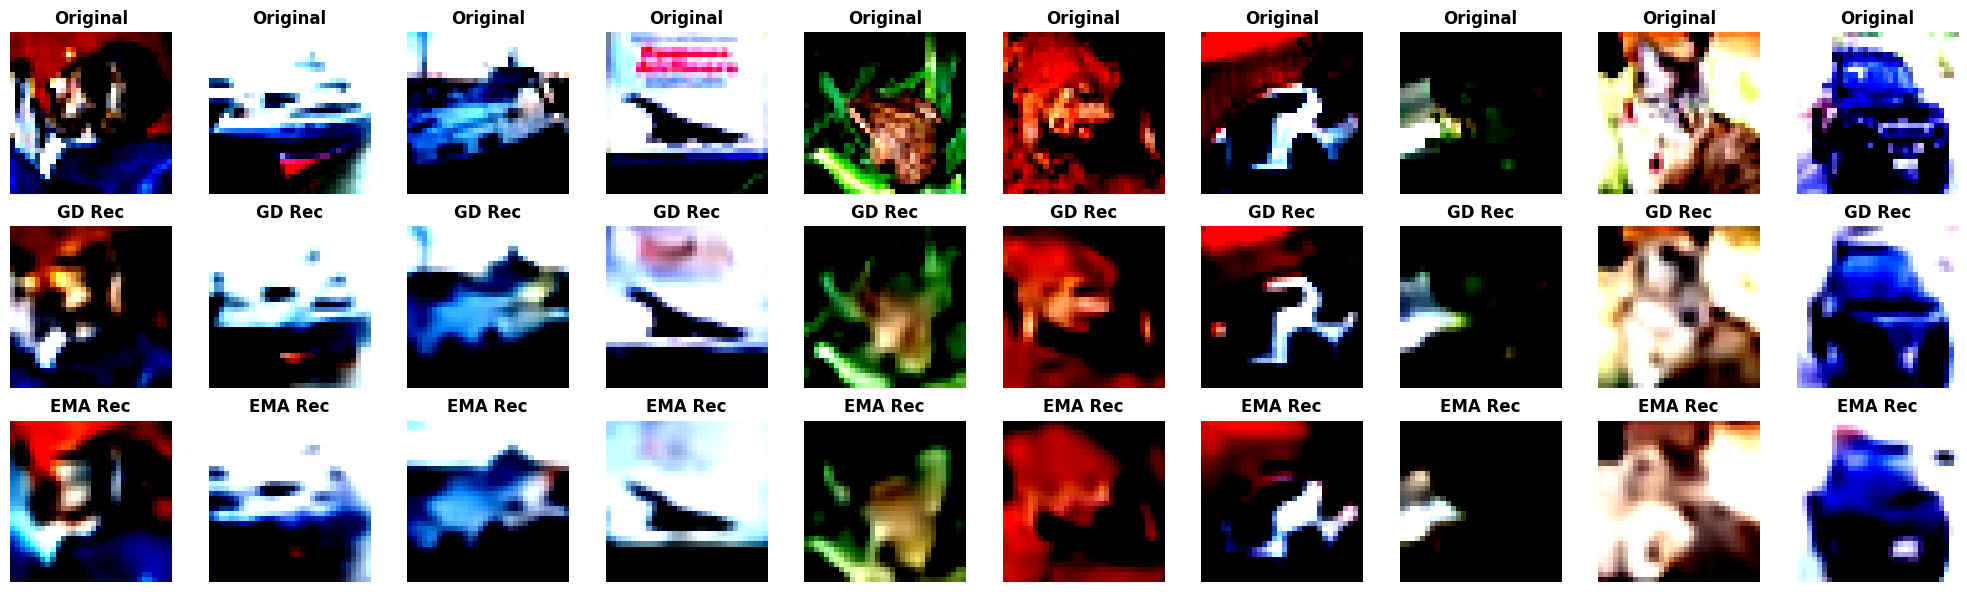

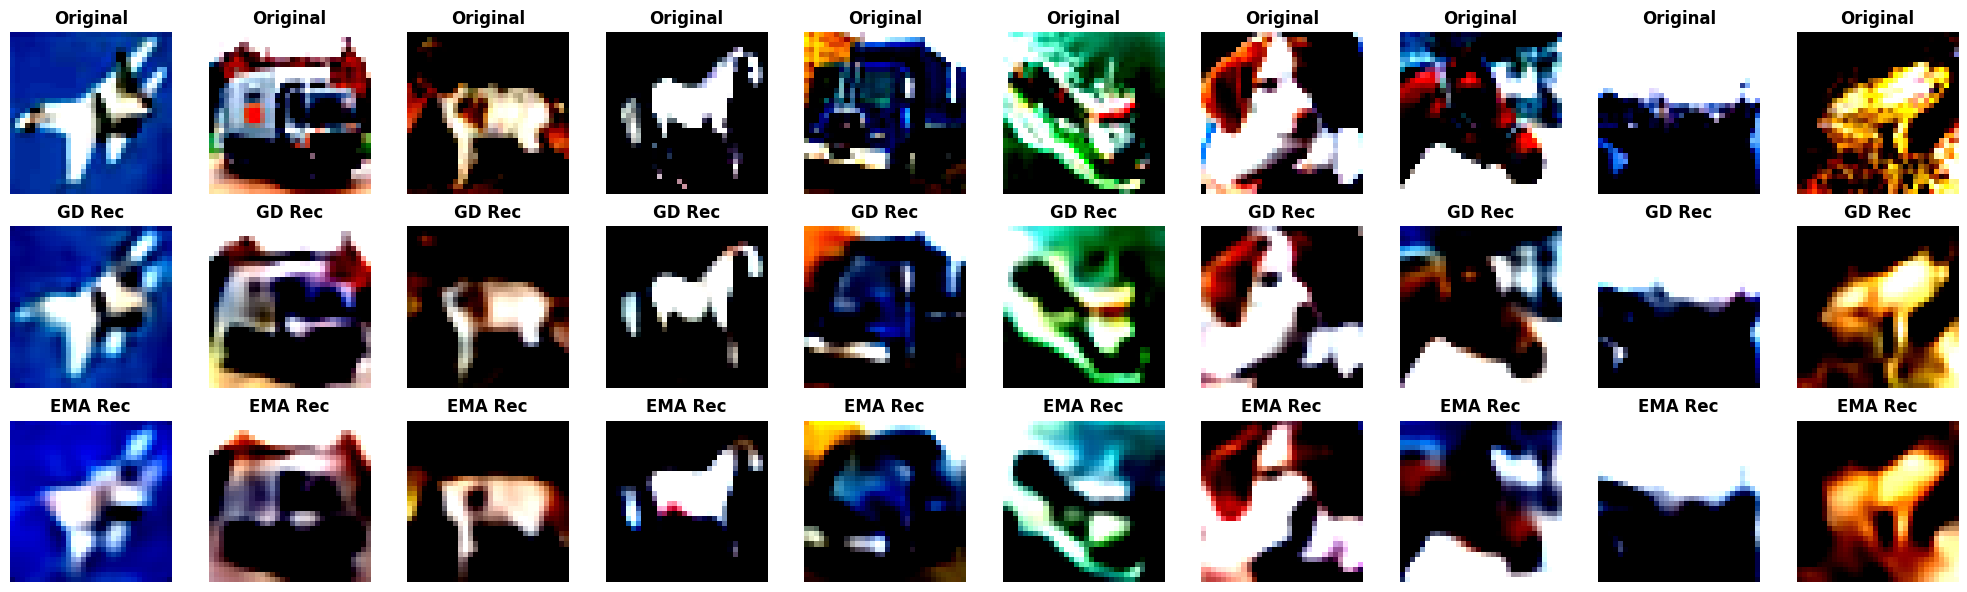

In [69]:
# Disable annoying warning about clipping image values
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

imgs, _ = next(iter(testloader))
rec_std, _, _, _ = std_state.apply_fn({'params': std_state.params}, imgs)
rec_ema, _, _ = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                              imgs, training=False)
plt.figure(figsize=(20, 6))
for i in range(10):
    ax = plt.subplot(3, 10, i + 1)
    img = imgs[i].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(3, 10, i + 11)
    img = rec_std[i].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("GD Rec", fontweight="bold")
    ax = plt.subplot(3, 10, i + 21)
    img = rec_ema[i].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("EMA Rec", fontweight="bold")
plt.tight_layout()

fig = plt.figure(figsize=(20, 6))
for i in range(10):
    ax = plt.subplot(3, 10, i + 1)
    img = imgs[i+10].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(3, 10, i + 11)
    img = rec[i+10].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("GD Rec", fontweight="bold")
    ax = plt.subplot(3, 10, i + 21)
    img = rec_ema[i+10].reshape((32, 32, 3))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("EMA Rec", fontweight="bold")
plt.tight_layout()

# Set warning level back
logger.setLevel(old_level)

Looking qualitatively at the results obtained, the images seem blurrier with the EMA method. For the same number of epochs, the model is trained **a bit faster with EMA** (wall time of 8min 57s vs 9min 9s with Gradient Descent). However, with the drop in image quality, this does not seem like a good trade-off. A better choice of hyperparameters ($\gamma$ and $\epsilon$) might bring better results.